***
***

# Introduction to Pytorch


***
***


<img src= 'img/neuralnetwork/softmax-regression-scalargraph.png' width= "500px">



# WHAT IS PYTORCH?

It’s a Python-based scientific computing package targeted at two sets of audiences:

- A replacement for NumPy to use the power of GPUs
- a deep learning research platform that provides maximum flexibility and speed

https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

PyTorch is the fastest growing Deep Learning framework
- it is also used by Fast.ai in its MOOC, Deep Learning for Coders and its library.
- PyTorch is also very pythonic

PyTorch makes it much easier and more intuitive to build a Deep Learning model in Python
- autograd, 
- dynamic computation graph, 
- model classes and more
- avoid some common pitfalls and errors

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np

In [52]:
# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y=1+2*x+.1*np.random.randn(100,1)
# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

In [3]:
# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

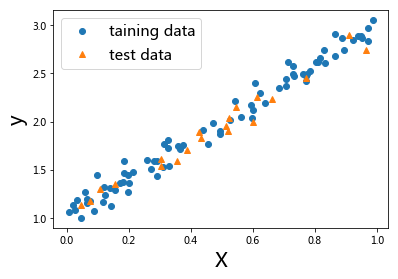

In [4]:
plt.plot(x_train, y_train, 'o', label = 'taining data')
plt.plot(x_val, y_val, '^', label = 'test data')
plt.xlabel('X', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.legend(fontsize = 15);

# Gradient Descent


<img src= 'img/neuralnetwork/loss.png' width= "200px">

<img src= 'img/neuralnetwork/gradient2.png' width= "500px">

<img src= 'img/neuralnetwork/gradient3.png' width= "200px">

# Linear Regression in Numpy


For training a model, there are two initialization steps:
1. Random initialization of parameters/weights (we have only two, a and b) — lines 3 and 4;
2. Initialization of hyper-parameters (in our case, only learning rate and number of epochs) — lines 9 and 11;

In [5]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)
print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

[0.49671415] [-0.1382643]


For each epoch, there are four training steps:
1. Compute model’s predictions — this is the forward pass;
2. Compute the loss, using predictions and and labels and the appropriate loss function for the task at hand;
3. Compute the gradients for every parameter;
4. Update the parameters;

In [6]:
for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

[1.02354094] [1.96896411]


In [7]:
# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[1.02354075] [1.96896447]


if we don’t use batch gradient descent (our example does)
- we have to write an inner loop to perform the four training steps for 
    - either each individual point (stochastic) or 
    - n points (mini-batch).

# PyTorch


## Tensor
- A scalar (a single number) has zero dimensions, 
- a vector has one dimension, 
- a matrix has two dimensions and 
- a tensor has three or more dimensions. 

<img src= 'img/neuralnetwork/tensor.jpeg' width= "800px">

## Loading data: turning Numpy arrays into PyTorch tensors


In [8]:
import torch
import torch.optim as optim
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


In [9]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


In [11]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    print(a.grad)
    print(b.grad)
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-3.1125])
tensor([-1.8156])
tensor([-2.3184])
tensor([-1.4064])
tensor([-1.7219])
tensor([-1.0982])
tensor([-1.2737])
tensor([-0.8659])
tensor([-0.9372])
tensor([-0.6906])
tensor([-0.6845])
tensor([-0.5583])
tensor([-0.4948])
tensor([-0.4582])
tensor([-0.3526])
tensor([-0.3824])
tensor([-0.2459])
tensor([-0.3248])
tensor([-0.1660])
tensor([-0.2810])
tensor([-0.1063])
tensor([-0.2475])
tensor([-0.0616])
tensor([-0.2218])
tensor([-0.0283])
tensor([-0.2019])
tensor([-0.0036])
tensor([-0.1864])
tensor([0.0147])
tensor([-0.1743])
tensor([0.0283])
tensor([-0.1646])
tensor([0.0382])
tensor([-0.1568])
tensor([0.0453])
tensor([-0.1505])
tensor([0.0505])
tensor([-0.1452])
tensor([0.0541])
tensor([-0.1408])
tensor([0.0566])
tensor([-0.1370])
tensor([0.0582])
tensor([-0.1337])
tensor([0.0592])
tensor([-0.1307])
tensor([0.0597])
tensor([-0.1280])
tensor([0.0599])
tensor([-0.1255])
tensor([0.0598])
tensor([-0.1232])
tensor([0.0594])
tensor([-0.1211])
tensor([0.0590])
tensor([-0.1190])
tensor

tensor([0.0001])
tensor([-0.0003])
tensor([0.0001])
tensor([-0.0003])
tensor([0.0001])
tensor([-0.0003])
tensor([0.0001])
tensor([-0.0003])
tensor([0.0001])
tensor([-0.0003])
tensor([0.0001])
tensor([-0.0003])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([0.0001])
tensor([-0.0002])
tensor([9.9594e-05])
tensor([-0.0002])
tensor([9.7900e-05])
tensor([-0.0002])
tensor([9.6527e-05])
tensor([-0.0002])
tensor([9.5085e-05])
tensor([-0.0002])
tensor([9.3636e-05])
tensor([-0.0002])
tensor([9.2130e-05])
tensor([-0.000

tensor([6.1168e-06])
tensor([-1.1602e-05])
tensor([6.0374e-06])
tensor([-1.1412e-05])
tensor([5.9709e-06])
tensor([-1.1222e-05])
tensor([5.8024e-06])
tensor([-1.1109e-05])
tensor([5.6330e-06])
tensor([-1.0981e-05])
tensor([5.4591e-06])
tensor([-1.0858e-05])
tensor([5.2679e-06])
tensor([-1.0748e-05])
tensor([5.3230e-06])
tensor([-1.0534e-05])
tensor([5.3825e-06])
tensor([-1.0292e-05])
tensor([5.1946e-06])
tensor([-1.0184e-05])
tensor([5.2743e-06])
tensor([-9.9508e-06])
tensor([5.2585e-06])
tensor([-9.7615e-06])
tensor([5.1573e-06])
tensor([-9.6367e-06])
tensor([5.1380e-06])
tensor([-9.4601e-06])
tensor([5.0936e-06])
tensor([-9.3075e-06])
tensor([4.9816e-06])
tensor([-9.1954e-06])
tensor([4.9298e-06])
tensor([-9.0375e-06])
tensor([4.8937e-06])
tensor([-8.8774e-06])
tensor([4.7355e-06])
tensor([-8.7903e-06])
tensor([4.5751e-06])
tensor([-8.7056e-06])
tensor([4.4171e-06])
tensor([-8.6267e-06])
tensor([4.2355e-06])
tensor([-8.5554e-06])
tensor([4.0668e-06])
tensor([-8.4818e-06])
tensor([4.1

tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4

## Dynamic Computation Graph


In [23]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

![](./img/neuralnetwork/comgraph.png)

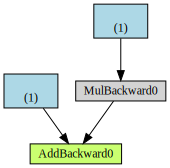

In [24]:
make_dot(yhat)

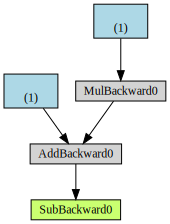

In [27]:
make_dot(error)

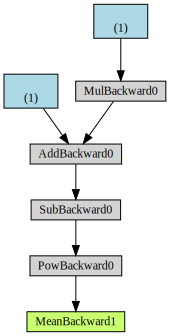

In [25]:
make_dot(loss)

## Optimizer


In [13]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Loss

In [14]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')
# optimizer in action!
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Model

In [41]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In [42]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('a', tensor([0.3367])), ('b', tensor([0.1288]))])
OrderedDict([('a', tensor([1.0235])), ('b', tensor([1.9690]))])


## Nested Models

In [43]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer 
        # with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

## Sequential Models

In [44]:
# Alternatively, you can use a Sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)

## Training Step

In [45]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.2191]])), ('0.bias', tensor([0.2018]))])


## Dataset

In [46]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))
(tensor([0.7713]), tensor([2.4745]))


## DataLoader

In [47]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [48]:
next(iter(train_loader))

[tensor([[0.4561],
         [0.3745],
         [0.1987],
         [0.7608],
         [0.1196],
         [0.1997],
         [0.7751],
         [0.2713],
         [0.6233],
         [0.9699],
         [0.0452],
         [0.0254],
         [0.8662],
         [0.7081],
         [0.8872],
         [0.1560]]), tensor([[1.7706],
         [1.7578],
         [1.2654],
         [2.4970],
         [1.3214],
         [1.3651],
         [2.4936],
         [1.5105],
         [2.2940],
         [2.9727],
         [0.9985],
         [1.0785],
         [2.6805],
         [2.3660],
         [2.8708],
         [1.2901]])]

In [49]:
losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.2191]])), ('0.bias', tensor([0.2018]))])


## Random Split


In [53]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

## Evaluation

In [54]:
losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.2191]])), ('0.bias', tensor([0.2018]))])


## All together

In [55]:
# https://gist.github.com/dvgodoy/1d818d86a6a0dc6e7c07610835b46fe4
torch.manual_seed(42)

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset with ALL data
dataset = TensorDataset(x_tensor, y_tensor)
# Splits randomly into train and validation datasets
train_dataset, val_dataset = random_split(dataset, [80, 20])
# Builds a loader for each dataset to perform mini-batch gradient descent
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

# Builds a simple sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)
print(model.state_dict())

# Sets hyper-parameters
lr = 1e-1
n_epochs = 150

# Defines loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []
val_losses = []
# Creates function to perform train step from model, loss and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Training loop
for epoch in range(n_epochs):
    # Uses loader to fetch one mini-batch for training
    for x_batch, y_batch in train_loader:
        # NOW, sends the mini-batch data to the device
        # so it matches location of the MODEL
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # One stpe of training
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    # After finishing training steps for all mini-batches,
    # it is time for evaluation!
        
    # We tell PyTorch to NOT use autograd...
    # Do you remember why?
    with torch.no_grad():
        # Uses loader to fetch one mini-batch for validation
        for x_val, y_val in val_loader:
            # Again, sends data to same device as model
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            # What is that?!
            model.eval()
            # Makes predictions
            yhat = model(x_val)
            # Computes validation loss
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

print(model.state_dict())
print(np.mean(losses))
print(np.mean(val_losses))

OrderedDict([('0.weight', tensor([[-0.9676]])), ('0.bias', tensor([-0.5727]))])
OrderedDict([('0.weight', tensor([[1.9625]])), ('0.bias', tensor([1.0147]))])
0.048798722923422855
0.020732787313560645


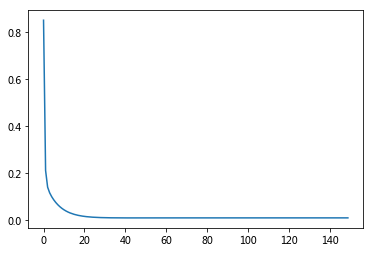

In [58]:
plt.plot(val_losses);

# torchviz

https://github.com/szagoruyko/pytorchviz/

> conda install graphviz

> pip install torchviz

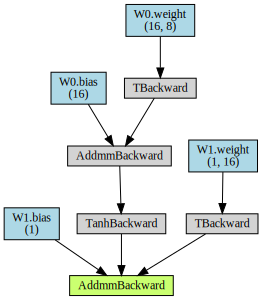

In [1]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace

model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1,8)

make_dot(model(x), params=dict(model.named_parameters()))

<!--NAVIGATION-->
< [In-Depth: Decision Trees and Random Forests](09.08-Random-Forests.ipynb) | [Contents](Index.ipynb) |[In-Depth: Neural Network Advanced](09.10.neural_network_advanced.ipynb)>